# Task 1 : EDA

In [7]:
#import all necessay libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, average_precision_score,
    confusion_matrix, mean_squared_error, mean_absolute_error, r2_score,
)
from sklearn.multioutput import MultiOutputRegressor
import joblib

In [ ]:
#read the csv
path = "/content/all_data_cleaned.csv"
df= pd.read_csv(path, sep = ";", decimal = ",")
df.head()

,Rock_number,EC_rock,Ph_rock,Corg_rock (%),Ca_rock,K_rock,Mg_rock,Na_rock,SAR_rock,SiO2_rock,...,Carbonate_leachate,Sulfate_leachate,Nitrate_leachate,Phosphate_leachate,Ca_leachate,Fe_leachate,K_leachate,Mg_leachate,Mn_leachate,Na_leachate
0,1,1351.0,8.11,0.05,22.24,0.16,3.09,0.15,0.04,21.78,...,8.8310,442.2810,0.8657,0.0828,106.6,12.31,0.49,7.68,9.74,0.005
1,1,1351.0,8.11,0.05,22.24,0.16,3.09,0.15,0.04,21.78,...,4.4515,741.6574,0.7168,0.3586,119.5,81.07,0.68,8.00,718.10,0.005
2,1,1351.0,8.11,0.05,22.24,0.16,3.09,0.15,0.04,21.78,...,3.4084,593.0435,0.4770,0.0735,249.0,60.54,0.70,8.96,929.70,0.005
3,1,1351.0,8.11,0.05,22.24,0.16,3.09,0.15,0.04,21.78,...,3.7481,656.4315,0.7683,0.8399,127.6,58.77,0.63,6.85,606.60,0.005
4,1,1351.0,8.11,0.05,22.24,0.16,3.09,0.15,0.04,21.78,...,4.1614,657.1826,0.6421,0.1142,141.6,44.95,0.56,7.56,710.90,0.005


## Data Understanding

In [ ]:
df.shape

(558, 39)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rock_number         558 non-null    int64  
 1   EC_rock             558 non-null    float64
 2   Ph_rock             558 non-null    float64
 3   Corg_rock (%)       558 non-null    float64
 4   Ca_rock             558 non-null    float64
 5   K_rock              558 non-null    float64
 6   Mg_rock             558 non-null    float64
 7   Na_rock             558 non-null    float64
 8   SAR_rock            558 non-null    float64
 9   SiO2_rock           558 non-null    float64
 10  Al2O3_rock          558 non-null    float64
 11  Fe2O3_rock          558 non-null    float64
 12  TiO2_rock           558 non-null    float64
 13  MnO_rock            558 non-null    float64
 14  CaO_rock            558 non-null    float64
 15  MgO_rock            558 non-null    float64
 16  Na2O_roc

In [ ]:
#Rename Corg_rock (%) to Corg_rock to have the same suffix for all rock properties
df=df.rename(columns={"Corg_rock (%)": "Corg_rock"})

In [ ]:
#Convert object dtype to float
cols_to_convert = [
       'EC_leachate', 'Ph_leachate']

for col in cols_to_convert:
    df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
    # Convert to numeric, coercing errors to NaN
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [ ]:
# Convert to categorical vars
cat_cols = ["Rock_number", "Type_event", "Acid"]
for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].astype("category")

# Create categorical temperature level: low (-5) vs high (50)
df["Temp_level"] = np.where(df["Temp"] <= 0, "low", "high")
df["Temp_level"] = df["Temp_level"].astype("category")

## Rock Properties Analysis

In [ ]:
rock_properties = [col for col in df.columns if col.endswith("_rock")]
leachate_columns = [col for col in df.columns if col.endswith("_leachate")]

In [ ]:
leachate_columns

['Volume_leachate',
 'EC_leachate',
 'Ph_leachate',
 'Chloride_leachate',
 'Carbonate_leachate',
 'Sulfate_leachate',
 'Nitrate_leachate',
 'Phosphate_leachate',
 'Ca_leachate',
 'Fe_leachate',
 'K_leachate',
 'Mg_leachate',
 'Mn_leachate',
 'Na_leachate']

In [ ]:
def summary_table(subset):
    desc = df[subset].describe().T
    desc["missing_%"] = df[subset].isna().mean() * 100
    return desc

summary_rock = summary_table(rock_properties)

print("\n--- Rock Feature Summary ---")
print(summary_rock)



--- Rock Feature Summary ---
            count        mean         std    min    25%    50%     75%  \
EC_rock     558.0  200.096774  346.602807  65.00  66.50  87.50  132.20   
Ph_rock     558.0    8.840896    0.259363   8.11   8.85   8.93    8.97   
Corg_rock   558.0    0.341004    0.365189   0.05   0.08   0.10    0.56   
Ca_rock     558.0    2.398172    5.954613   0.45   0.47   0.59    0.67   
K_rock      558.0    0.327312    0.259442   0.13   0.15   0.15    0.45   
Mg_rock     558.0    0.564158    0.773849   0.10   0.27   0.33    0.50   
Na_rock     558.0    0.084624    0.035629   0.04   0.05   0.07    0.13   
SAR_rock    558.0    0.109211    0.039075   0.04   0.09   0.11    0.12   
SiO2_rock   558.0   43.009104   10.077418  21.78  43.42  46.29   49.30   
Al2O3_rock  558.0   13.743907    2.967619   7.38  14.51  14.87   15.64   
Fe2O3_rock  558.0    4.972151    1.018829   2.88   4.56   5.34    5.37   
TiO2_rock   558.0    0.378136    0.065730   0.29   0.36   0.39    0.40   
MnO_rock

In [ ]:
#since rock properties are the same for the same rock, it makes sense to have 7 rows
chem_prop = df.groupby("Rock_number")[rock_properties].first()
chem_prop

/tmp/ipython-input-855354915.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chem_prop = df.groupby("Rock_number")[rock_properties].first()


,EC_rock,Ph_rock,Corg_rock,Ca_rock,K_rock,Mg_rock,Na_rock,SAR_rock,SiO2_rock,Al2O3_rock,Fe2O3_rock,TiO2_rock,MnO_rock,CaO_rock,MgO_rock,Na2O_rock,K2O_rock,SO3_rock,P2O5_rock
Rock_number,,,,,,,,,,,,,,,,,,,
1,1351.0,8.11,0.05,22.24,0.16,3.09,0.15,0.04,21.78,7.38,3.16,0.39,0.03,20.55,2.88,0.22,0.36,24.65,0.01
2,136.5,8.50,0.09,1.04,0.13,0.58,0.08,0.09,33.41,11.65,4.37,0.55,0.11,19.31,5.35,0.11,1.20,0.11,0.03
3,87.5,9.06,0.24,0.45,0.25,0.33,0.04,0.06,24.59,7.72,2.88,0.36,0.06,30.68,2.91,0.25,1.59,0.29,0.04
4,66.5,8.93,0.10,0.47,0.15,0.27,0.07,0.12,46.29,15.89,6.14,0.29,0.19,9.29,3.72,0.40,3.39,0.03,0.10
5,132.2,8.85,0.98,0.66,0.79,0.47,0.13,0.17,49.30,14.87,5.37,0.39,0.08,8.92,4.22,0.54,3.30,0.05,0.17
6,126.0,9.04,0.56,0.67,0.45,0.50,0.08,0.11,43.42,14.51,4.56,0.36,0.04,19.64,4.46,0.51,2.65,0.45,0.11
7,65.0,8.97,0.08,0.59,0.15,0.10,0.05,0.09,52.11,15.64,5.34,0.40,0.08,5.85,3.84,0.57,3.10,0.04,0.14


/tmp/ipython-input-2297177211.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-2297177211.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-2297177211.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-2297177211.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-2297177211.py:6: FutureWarning: 

Passing `pa

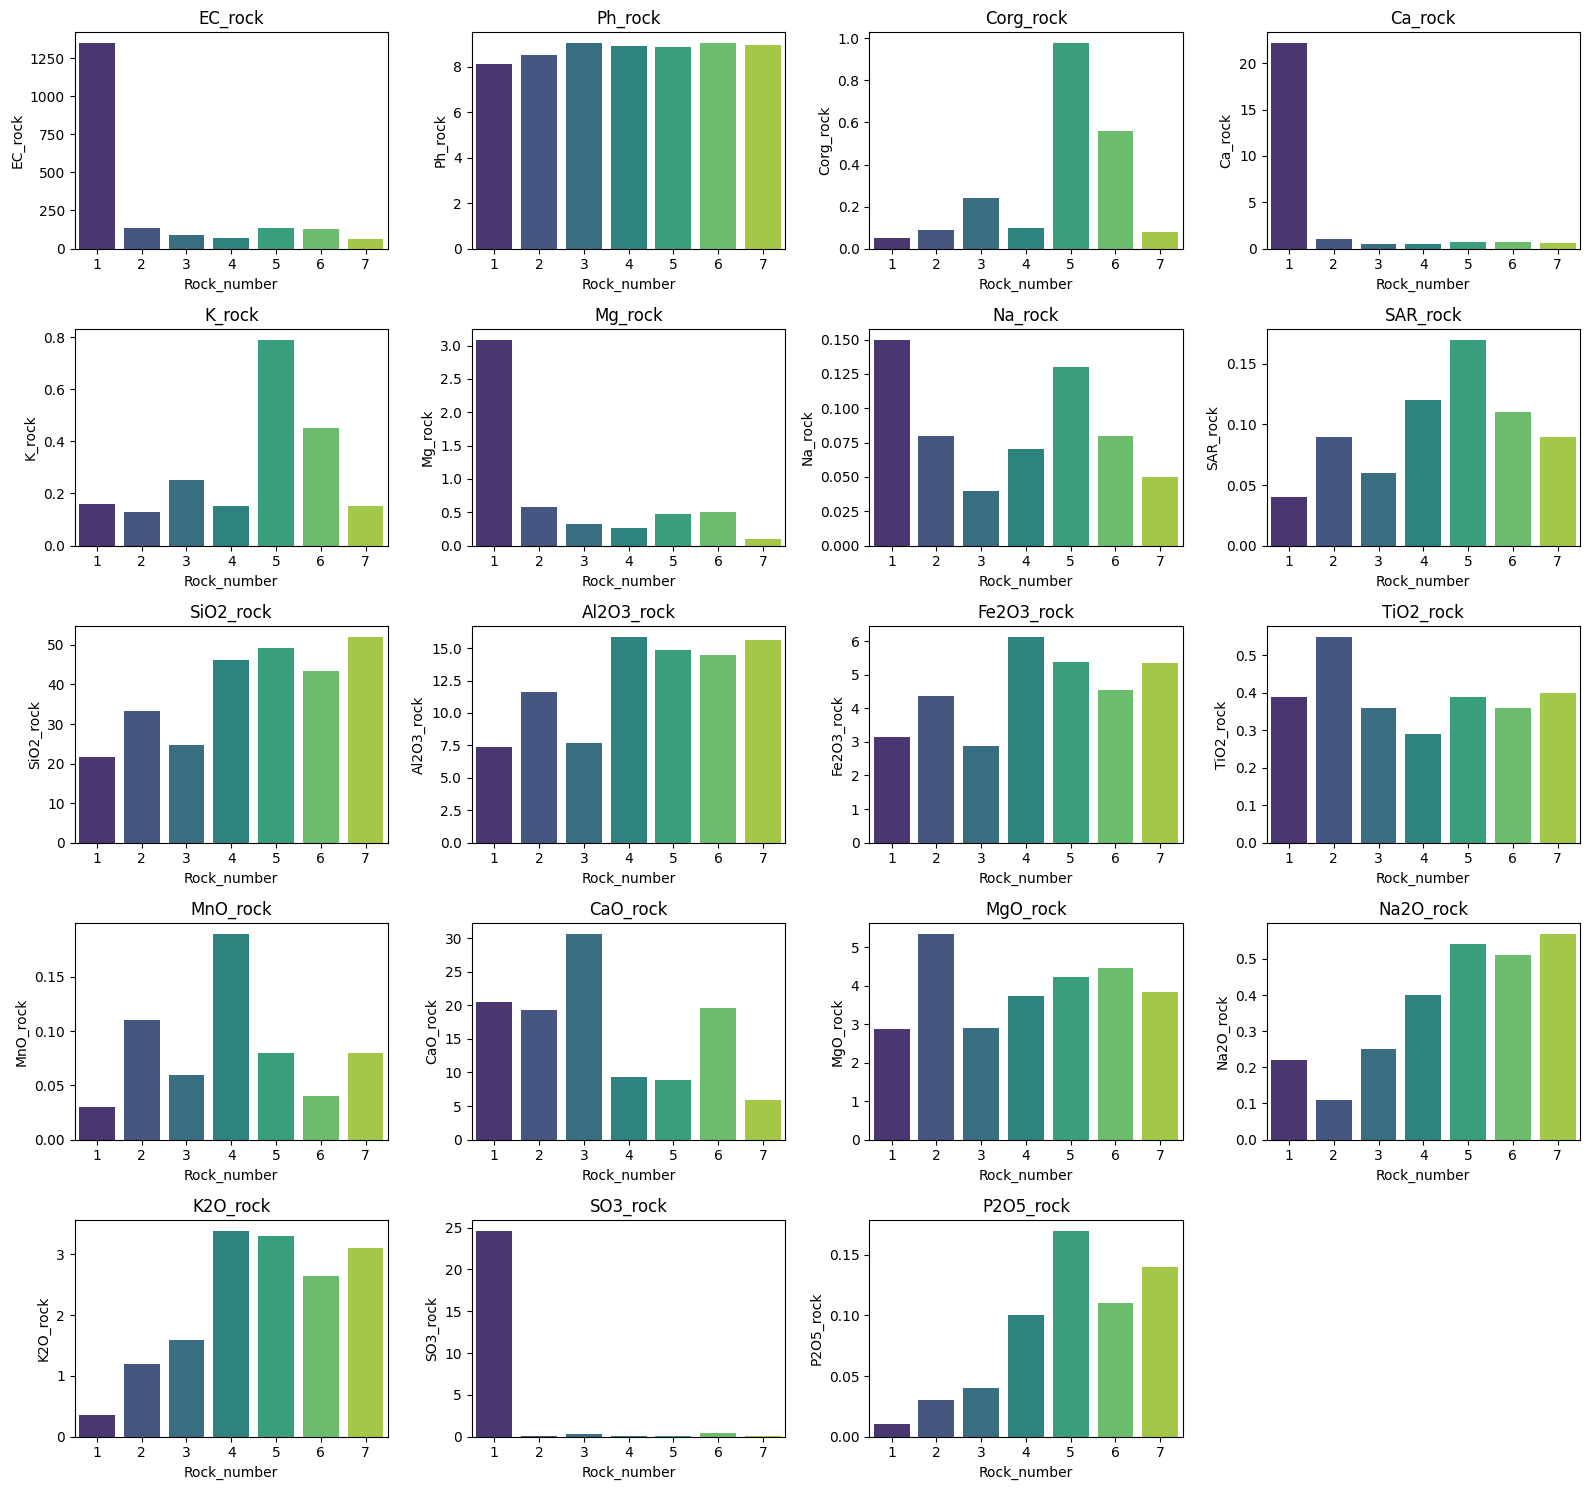

In [ ]:
n_cols = 4
n_rows = int(np.ceil(len(rock_properties) / n_cols))
plt.figure(figsize=(4 * n_cols, 3 * n_rows))
for i, col in enumerate(rock_properties, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.barplot(
        x=chem_prop.index.astype(str),
        y=chem_prop[col],
        palette="viridis"
    )
    plt.title(col)
    plt.xlabel("Rock_number")
plt.tight_layout()
plt.show()

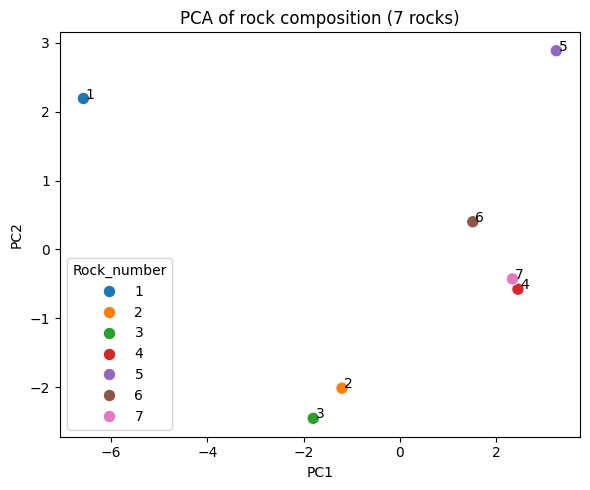

Explained variance ratio: [0.54441833 0.17967451]


In [ ]:
X = chem_prop.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame({
    "Rock_number": chem_prop.index.astype(str),
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1]
})

plt.figure(figsize=(6, 5))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Rock_number", s=80)
for _, row in pca_df.iterrows():
    plt.text(row["PC1"] + 0.05, row["PC2"], row["Rock_number"])
plt.title("PCA of rock composition (7 rocks)")
plt.tight_layout()
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)


## Understand Event Variables

In [ ]:
# 1. Basic counts of events
print(df[["Type_event", "Acid", "Temp_level"]].value_counts().rename("n_obs"))

Type_event  Acid  Temp_level
rain        0     low           150
                  high          129
snow        0     low            90
rain        1     high           60
                  low            60
snow        1     low            45
            0     high           24
Name: n_obs, dtype: int64


In [ ]:
# 2. Distribution of timesteps by rock & treatment
time_counts = (
    df.groupby(["Rock_number", "Type_event", "Acid", "Temp_level"])["Timestep"]
      .nunique()
      .rename("n_timesteps")
      .reset_index()
)
print(time_counts[time_counts['n_timesteps']!= 0].sort_values(["Rock_number", "Type_event", "Acid", "Temp_level"]))


   Rock_number Type_event Acid Temp_level  n_timesteps
0            1       rain    0       high            8
1            1       rain    0        low           15
4            1       snow    0       high            8
5            1       snow    0        low           15
8            2       rain    0       high            8
9            2       rain    0        low           15
12           2       snow    0       high            8
13           2       snow    0        low           15
16           3       rain    0       high            8
17           3       rain    0        low           15
20           3       snow    0       high            8
21           3       snow    0        low           15
24           4       rain    0       high           15
25           4       rain    0        low           15
26           4       rain    1       high           15
27           4       rain    1        low           15
29           4       snow    0        low           15
31        

/tmp/ipython-input-3653142765.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["Rock_number", "Type_event", "Acid", "Temp_level"])["Timestep"]


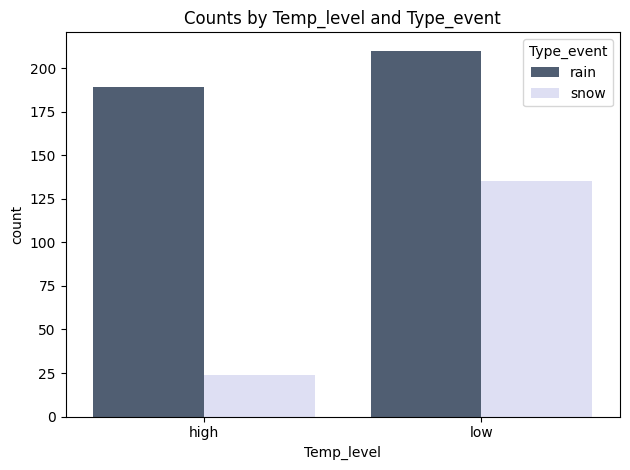

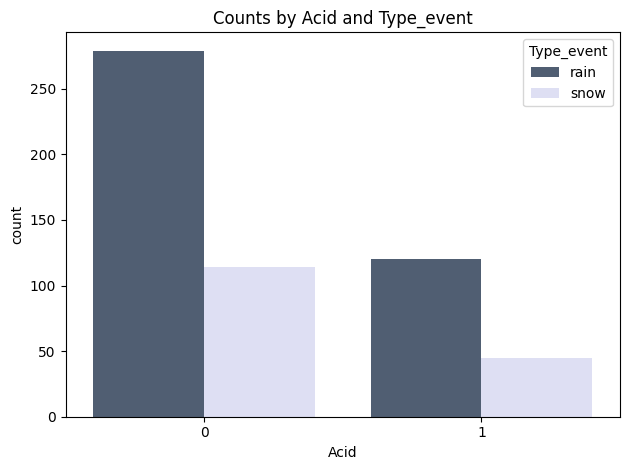

In [ ]:
# Distribution of Temp_level by event and Acid
sns.countplot(
    data=df,
    x="Temp_level",
    hue="Type_event",
    palette= ('#4A5D78', '#DADCF7')
)
plt.title("Counts by Temp_level and Type_event")
plt.tight_layout()
plt.show()

sns.countplot(
    data=df,
    x="Acid",
    hue="Type_event",
    palette= ('#4A5D78', '#DADCF7')
)
plt.title("Counts by Acid and Type_event")
plt.tight_layout()
plt.show()

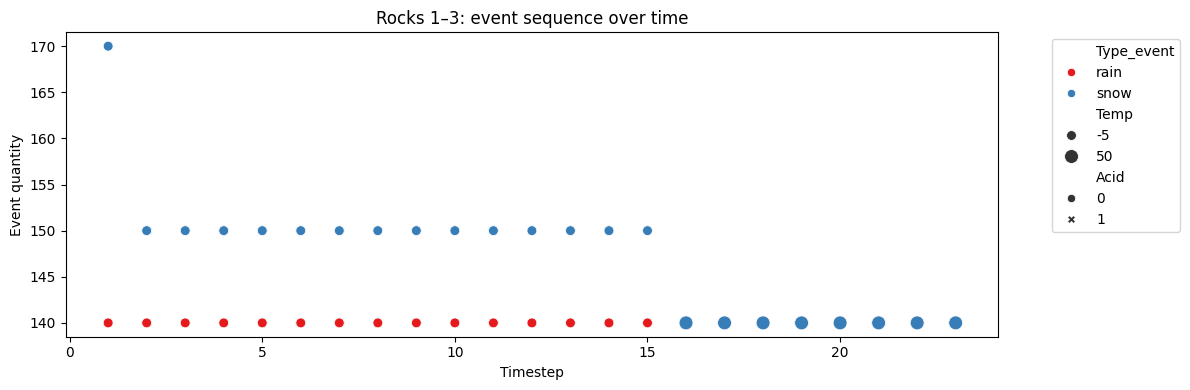

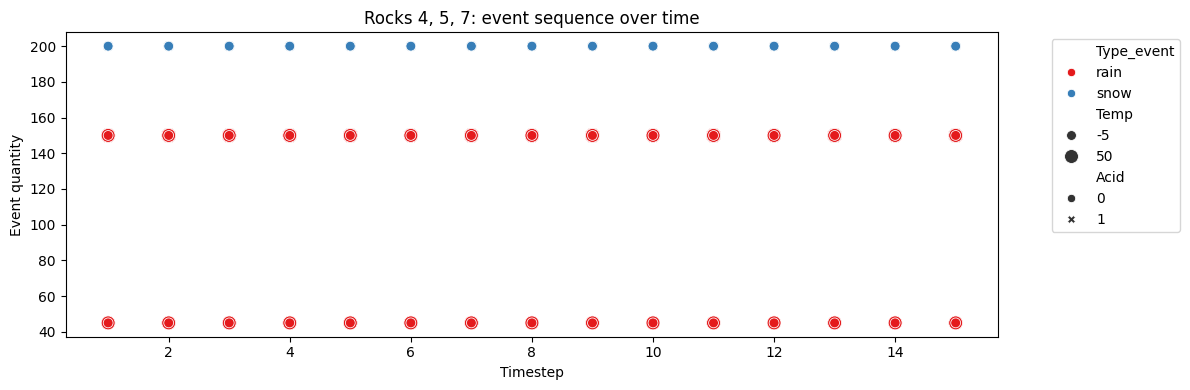

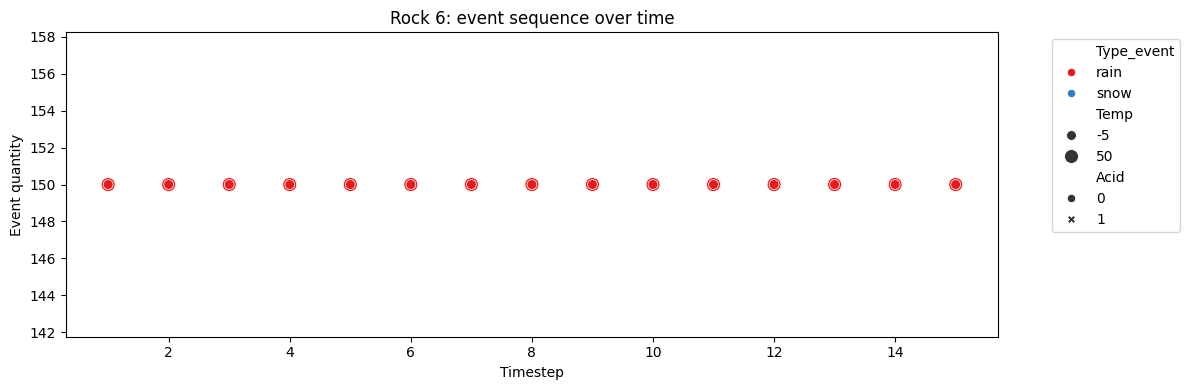

In [ ]:
rock_groups = {
    "Rocks 1–3": [1, 2, 3],
    "Rocks 4, 5, 7": [4, 5, 7],
    "Rock 6": [6],
}

for group_name, group_rocks in rock_groups.items():
    group_df = df[df["Rock_number"].isin(group_rocks)].copy()
    group_df = group_df.sort_values(["Rock_number", "Timestep"])

    plt.figure(figsize=(12, 4))
    sns.scatterplot(
        data=group_df,
        x="Timestep",
        y="Event_quantity",
        hue="Type_event",
        style="Acid",
        size="Temp",
        sizes={-5: 50, 50: 100},
        palette="Set1"
    )
    plt.title(f"{group_name}: event sequence over time")
    plt.xlabel("Timestep")
    plt.ylabel("Event quantity")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


## Leachate EDA

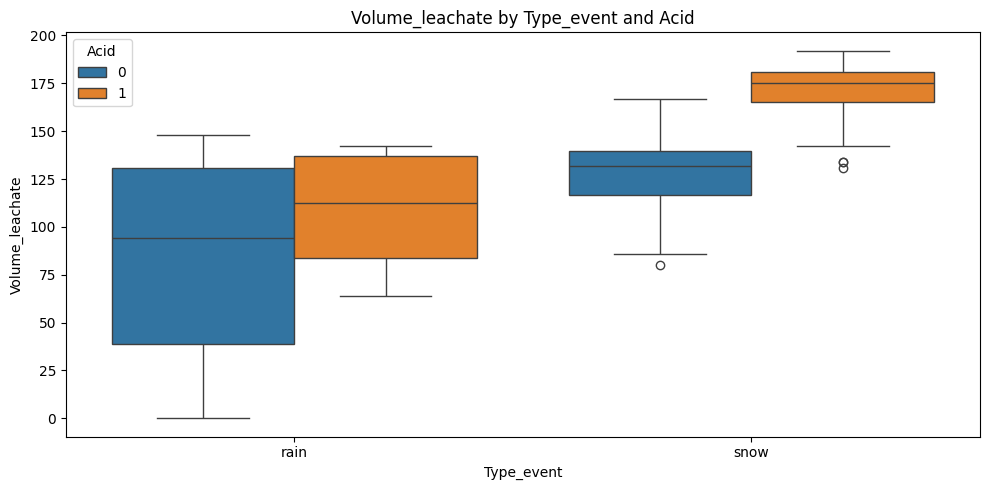

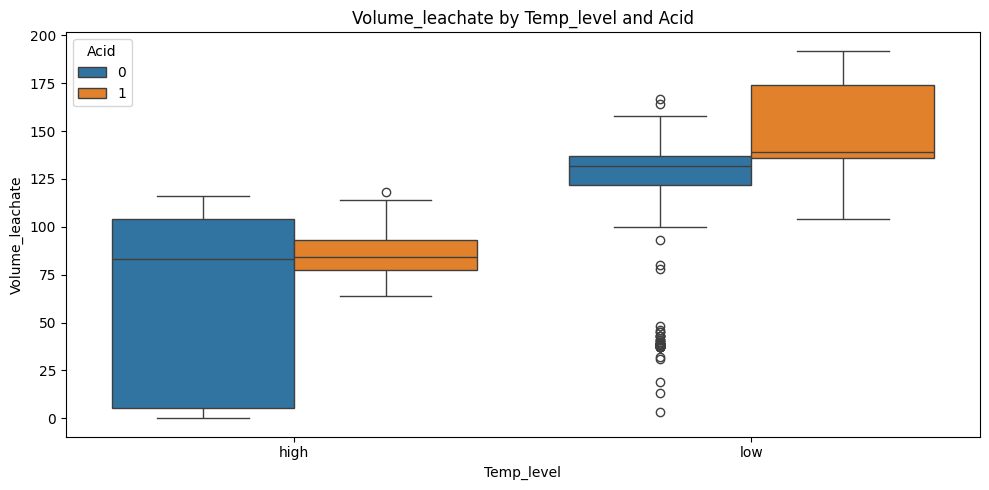

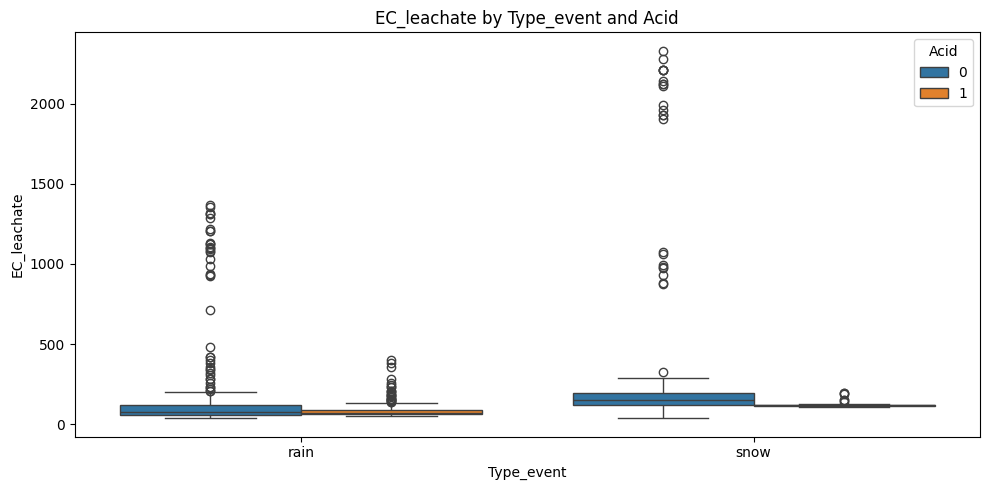

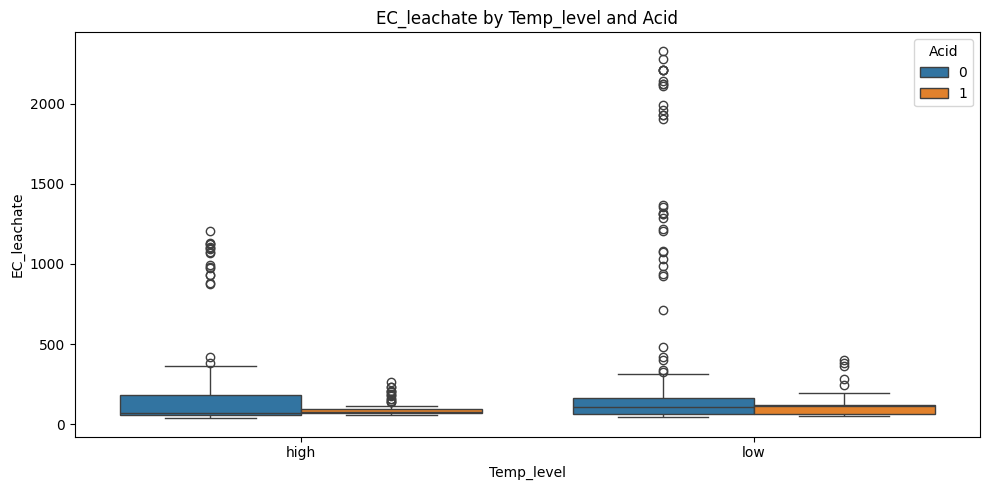

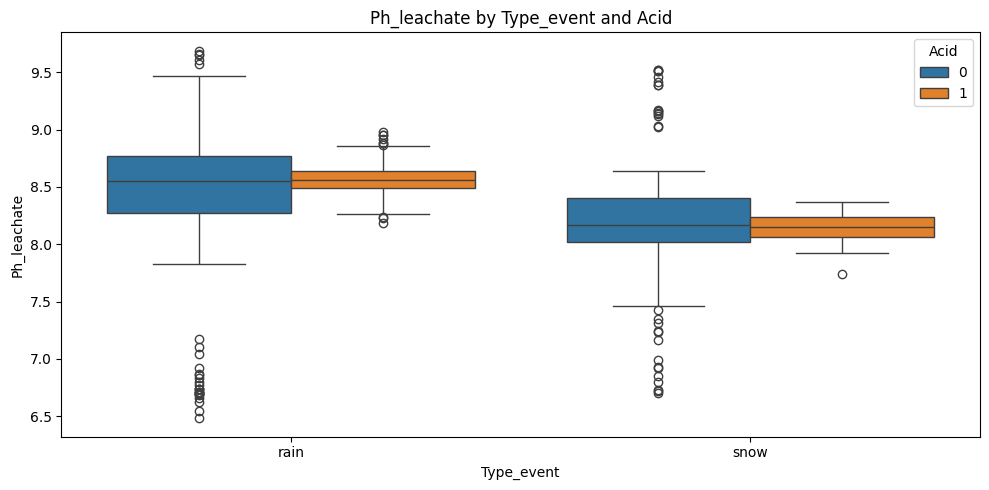

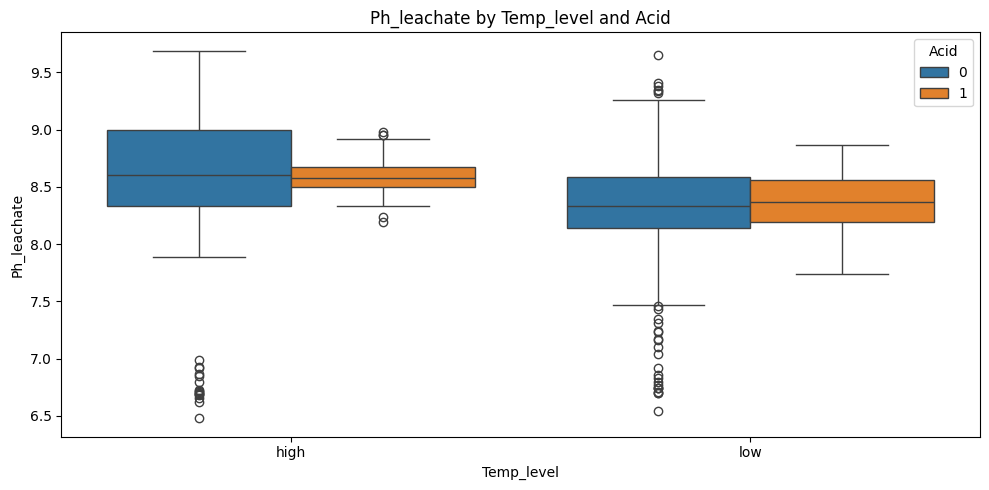

In [ ]:
leach_targets = ["Volume_leachate", "EC_leachate", "Ph_leachate"]
leach_targets = [c for c in leach_targets if c in df.columns]

for y in leach_targets:
    plt.figure(figsize=(10, 5))
    sns.boxplot(
        data=df,
        x="Type_event",
        y=y,
        hue="Acid"
    )
    plt.title(f"{y} by Type_event and Acid")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    sns.boxplot(
        data=df,
        x="Temp_level",
        y=y,
        hue="Acid"
    )
    plt.title(f"{y} by Temp_level and Acid")
    plt.tight_layout()
    plt.show()


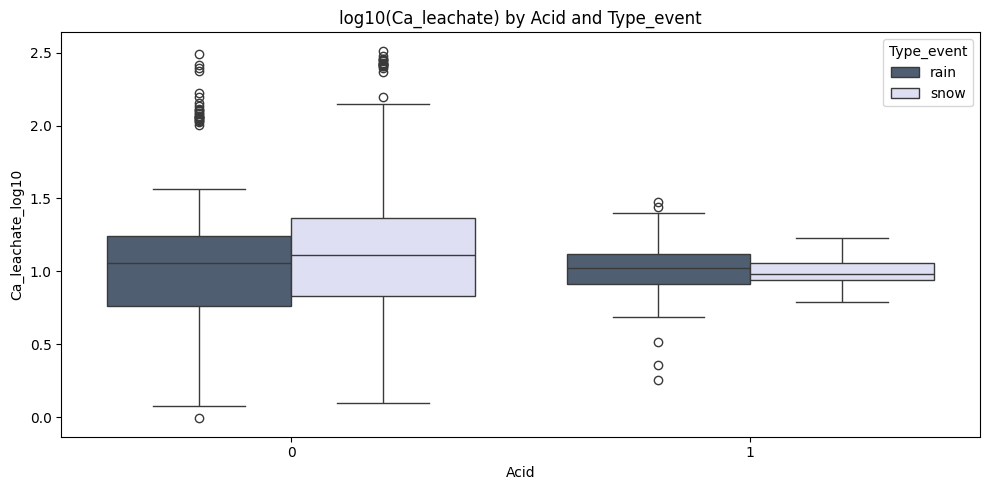

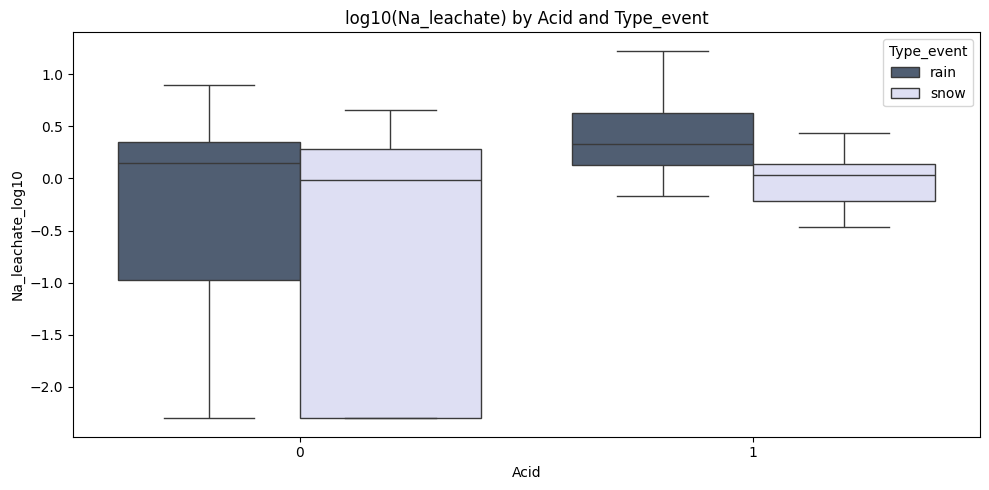

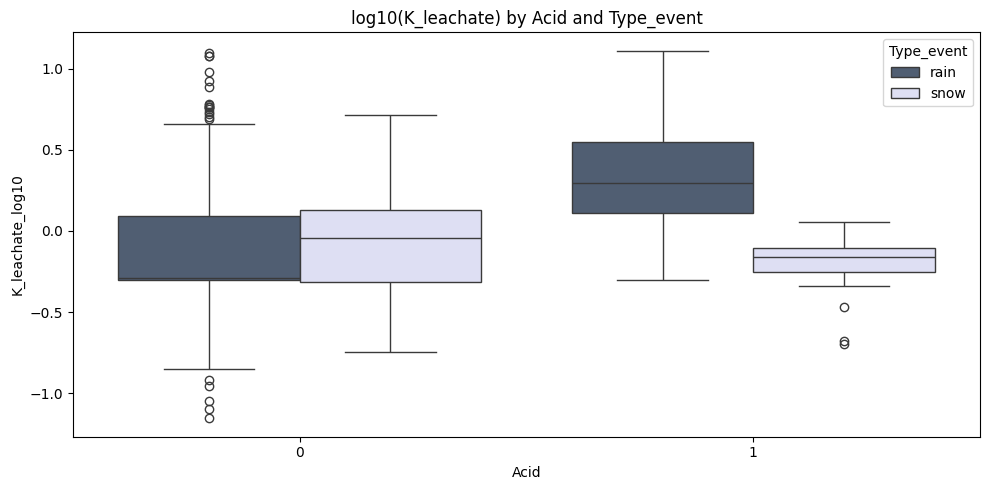

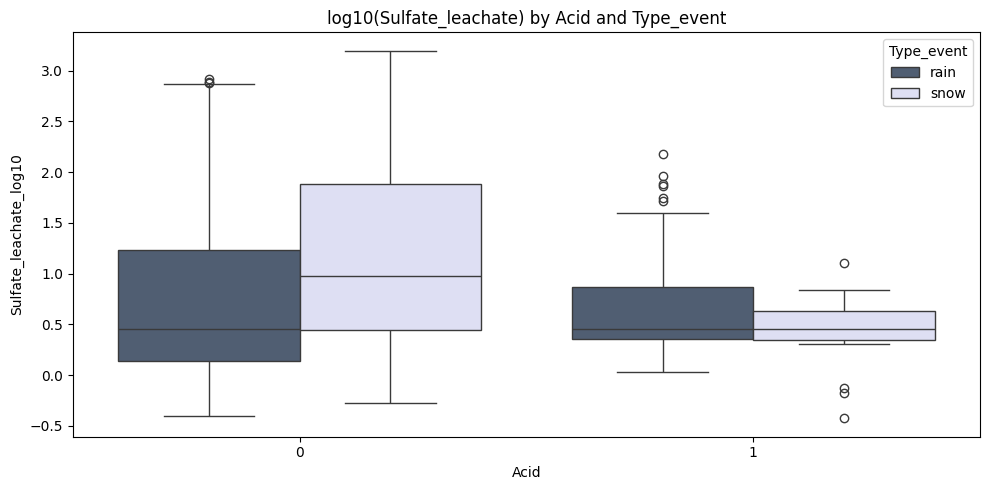

In [ ]:
ions = ["Ca_leachate", "Na_leachate", "K_leachate", "Sulfate_leachate"]
ions = [c for c in ions if c in df.columns]

for ion in ions:
    df_plot = df.copy()
    df_plot[ion + "_log10"] = np.where(df_plot[ion] > 0,
                                       np.log10(df_plot[ion]),
                                       np.nan)
    plt.figure(figsize=(10, 5))
    sns.boxplot(
        data=df_plot,
        x="Acid",
        y=ion + "_log10",
        hue="Type_event",
        palette= ('#4A5D78', '#DADCF7')
    )
    plt.title(f"log10({ion}) by Acid and Type_event")
    plt.tight_layout()
    plt.show()


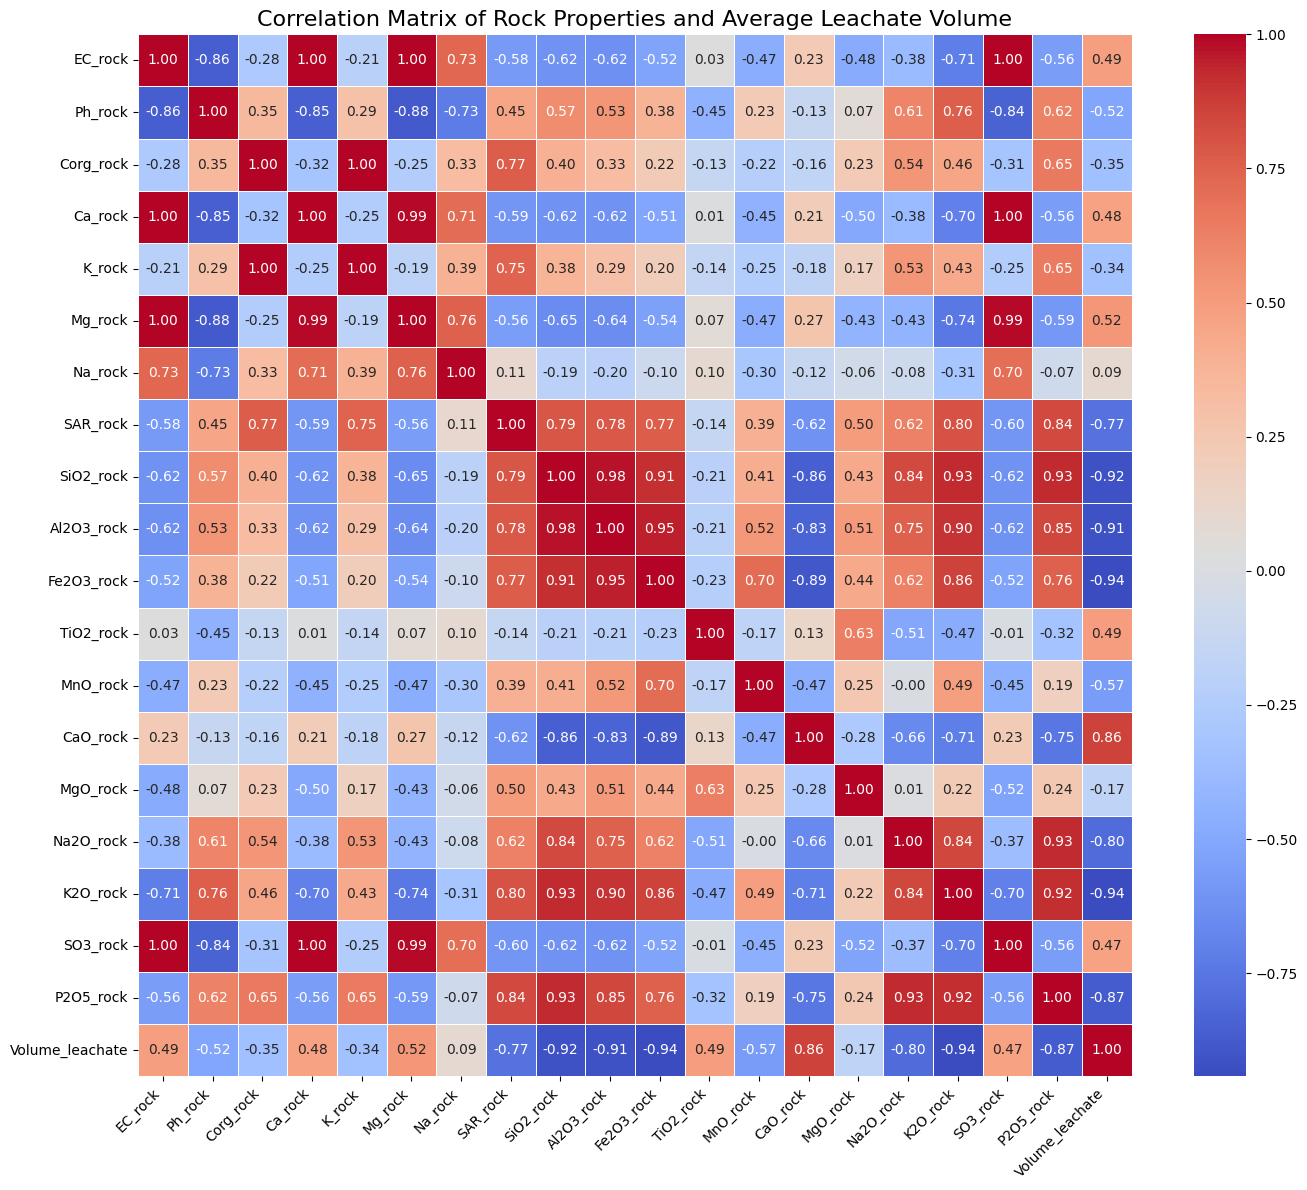

In [ ]:
corr = df.groupby("Rock_number", observed=False)[rock_properties + ["Volume_leachate"]].mean().corr()

plt.figure(figsize=(14, 12)) # Increase figure size for better readability
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix of Rock Properties and Average Leachate Volume", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Informative missigness

In [ ]:
leachate = [col for col in df.columns if col.endswith("_leachate") and col != "Volume_leachate"]

In [ ]:
# flag rows where ALL these chem columns are missing
df["low_volume"] = df[leachate].isna().all(axis=1)

# quick check
print(df["low_volume"].value_counts())

low_volume
False    522
True      36
Name: count, dtype: int64


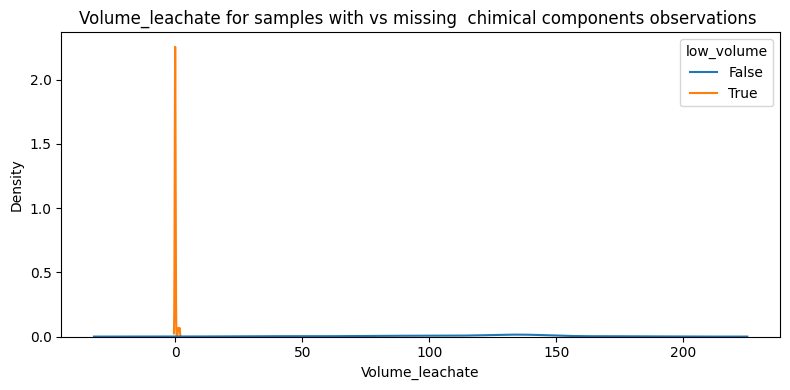

In [ ]:
plt.figure(figsize=(8,4))
sns.kdeplot(
    data=df,
    x="Volume_leachate",
    hue="low_volume",
    common_norm=False
)
plt.title("Volume_leachate for samples with vs missing  chimical components observations ")
plt.tight_layout()
plt.show()

In [ ]:
#print rock number and volume  rows where low_volume = true
df[df["low_volume"]==True][["Rock_number", "Type_event", "Acid", "Temp_level","Timestep",  "Volume_leachate"]]

,Rock_number,Type_event,Acid,Temp_level,Timestep,Volume_leachate
214,4,rain,0,high,10,0.0
215,4,rain,0,high,11,0.0
216,4,rain,0,high,12,0.0
217,4,rain,0,high,13,0.0
218,4,rain,0,high,14,0.0
219,4,rain,0,high,15,0.0
220,4,rain,0,high,2,0.0
221,4,rain,0,high,3,0.0
222,4,rain,0,high,4,0.0
223,4,rain,0,high,5,0.0


In [ ]:
low_vol_threshold = 1.7

In [ ]:
df[['Rock_number', "Type_event", "Acid", "Temp_level"]][df['Volume_leachate'] <= low_vol_threshold].drop_duplicates()

,Rock_number,Type_event,Acid,Temp_level
214,4,rain,0,high
334,5,rain,0,high
514,7,rain,0,high


#Task 2

## Pre-Processing

In [ ]:
# 1. Define columns
numeric_predictors = [
    'EC_rock', 'Ph_rock', 'Corg_rock', 'SAR_rock',
    'SiO2_rock', 'Al2O3_rock', 'Fe2O3_rock', 'SO3_rock',
    'CaO_rock', 'MgO_rock'
]

event_features= [
     'Type_event', 'Acid', 'Temp_level'
]

sequence_features = ['Timestep']
leachate_columns = [col for col in df.columns if col.endswith("_leachate")]

In [ ]:
# 2. Preprocessing function
def preprocess(df, numeric_predictors, event_features, scaler=None):
    df = df.copy()

    # Scale numeric predictors
    if scaler is None:
        scaler = StandardScaler()
        df[numeric_predictors] = scaler.fit_transform(df[numeric_predictors])
    else:
        df[numeric_predictors] = scaler.transform(df[numeric_predictors])

    # One-hot encode categorical event features
    df = pd.get_dummies(df, columns=event_features, drop_first=True)

    return df, scaler

# 3. Lag feature function
def add_lag_features(df, leach_cols, lags=[1,2,3]):
    df = df.sort_values(["Rock_number", "Timestep"]).copy()
    lag_cols = leach_cols + ["Volume_leachate"]

    for col in lag_cols:
        for lag in lags:
            df[f"{col}_lag{lag}"] = df.groupby("Rock_number")[col].shift(lag)

    lag1_cols = [f"{c}_lag1" for c in lag_cols]
    df = df.dropna(subset=lag1_cols)  # drop first timesteps without lag1

    return df

In [ ]:
# 4. Split by rocks (avoid leakage)
test_rocks = [3,5]  # example rocks for testing
train_mask = ~df["Rock_number"].isin(test_rocks)
test_mask  = df["Rock_number"].isin(test_rocks)

df_train = df[train_mask].copy()
df_test  = df[test_mask].copy()

In [ ]:
# 5. Create Measured column for classifier
df_train["Measured"] = (~df_train["low_volume"]).astype(int)
df_test["Measured"]  = (~df_test["low_volume"]).astype(int)


In [ ]:
# 6. Impute leachate columns only for measured rows
imputer = KNNImputer(n_neighbors=5, weights="distance")

# Train
measured_train_mask = df_train["Measured"]==1
df_train.loc[measured_train_mask, leachate_columns] = \
    imputer.fit_transform(df_train.loc[measured_train_mask, leachate_columns])

# Test
measured_test_mask = df_test["Measured"]==1
df_test.loc[measured_test_mask, leachate_columns] = \
    imputer.transform(df_test.loc[measured_test_mask, leachate_columns])


In [ ]:
# 7. Add lag features (after imputation)
df_train = add_lag_features(df_train, leachate_columns)
df_test  = add_lag_features(df_test, leachate_columns)


/tmp/ipython-input-3361266796.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[f"{col}_lag{lag}"] = df.groupby("Rock_number")[col].shift(lag)
/tmp/ipython-input-3361266796.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[f"{col}_lag{lag}"] = df.groupby("Rock_number")[col].shift(lag)
/tmp/ipython-input-3361266796.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[f"{col}_lag{lag}"] = df.groupby("Rock_nu

In [ ]:
# 8. Preprocess features
df_train, scaler = preprocess(df_train, numeric_predictors, event_features, scaler= None )
df_test, _       = preprocess(df_test, numeric_predictors, event_features, scaler = scaler)


## XGB_class Training

In [ ]:
# 9. Define features for classifier and regressor
features_clf = numeric_predictors + \
               [c for c in df_train.columns if c.startswith(tuple(event_features))] + \
               [c for c in df_train.columns if "lag" in c]

# 10. Train classifier
X_train_clf = df_train[features_clf].fillna(-999)
X_test_clf  = df_test[features_clf].fillna(-999)
y_train_clf = df_train["Measured"]
y_test_clf  = df_test["Measured"]

# XGB classifier (handle class imbalance)
pos = y_train_clf.sum()
neg = len(y_train_clf) - pos
scale_pos_weight = neg / (pos + 1e-9)

xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=42
)
xgb_clf.fit(X_train_clf, y_train_clf)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

## XGB_class results

In [ ]:
# Evaluate classifier
probs = xgb_clf.predict_proba(X_test_clf)[:,1]
preds = (probs >= 0.5).astype(int)
print("Classifier Metrics:")
print("Accuracy:", accuracy_score(y_test_clf, preds))
print("Precision:", precision_score(y_test_clf, preds))
print("Recall:", recall_score(y_test_clf, preds))
print("F1:", f1_score(y_test_clf, preds))
print("ROC AUC:", roc_auc_score(y_test_clf, probs))
print("Confusion Matrix:\n", confusion_matrix(y_test_clf, preds))

Classifier Metrics:
Accuracy: 0.9868421052631579
Precision: 1.0
Recall: 0.9857142857142858
F1: 0.9928057553956835
ROC AUC: 1.0
Confusion Matrix:
 [[ 12   0]
 [  2 138]]


## XGB_reg Model Training

In [11]:
#choice of these columns based on previous model
log_targets = [
    'EC_leachate', 'Chloride_leachate', 'Carbonate_leachate',
    'Sulfate_leachate', 'Nitrate_leachate', 'Phosphate_leachate',
    'Ca_leachate', 'Fe_leachate', 'K_leachate',
    'Mg_leachate', 'Mn_leachate', 'Na_leachate'
]

linear_targets = [
    'Volume_leachate', 'Ph_leachate'
]


In [ ]:
X_train_reg = df_train.loc[measured_train_mask, features_clf].copy()
y_train_reg = df_train.loc[measured_train_mask, leachate_columns].copy()
X_test_reg  = df_test.loc[measured_test_mask, features_clf].copy()
y_test_reg  = df_test.loc[measured_test_mask, leachate_columns].copy()
y_train_reg = df_train.loc[measured_train_mask, leachate_columns].copy()
y_test_reg  = df_test.loc[measured_test_mask, leachate_columns].copy()

# Apply log1p only where needed
y_train_reg_log = y_train_reg.copy()
y_test_reg_log  = y_test_reg.copy()

y_train_reg_log[log_targets] = np.log1p(y_train_reg[log_targets])
y_test_reg_log[log_targets]  = np.log1p(y_test_reg[log_targets])


In [ ]:
param_grid = {
    "estimator__n_estimators": [300, 500, 800],
    "estimator__max_depth": [3, 4, 5, 6],
    "estimator__learning_rate": [0.01, 0.03, 0.05],
    "estimator__subsample": [0.7, 0.8, 0.9],
    "estimator__colsample_bytree": [0.7, 0.8, 0.9],
    "estimator__min_child_weight": [1, 5, 10]
}


In [ ]:
best_models = {}
y_pred = pd.DataFrame(index=y_test_reg.index, columns=leachate_columns)

for target in leachate_columns:
    print(f"\n==============================")
    print(f"Tuning regressor for target: {target}")

    xgb = XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_grid,  # make sure param_grid is defined
        n_iter=10,
        scoring="neg_root_mean_squared_error",
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    # Fit only on this target
    search.fit(X_train_reg, y_train_reg_log[target])

    best_models[target] = search.best_estimator_
    print("Best params:", search.best_params_)

    # Predict on test set
    y_pred[target] = search.best_estimator_.predict(X_test_reg)

# Inverse log-transform for selected targets
y_pred[log_targets] = np.expm1(y_pred[log_targets])



Tuning regressor for target: Volume_leachate
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:23:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "estimator__colsample_bytree", "estimator__learning_rate", "estimator__max_depth", "estimator__min_child_weight", "estimator__n_estimators", "estimator__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'estimator__subsample': 0.9, 'estimator__n_estimators': 300, 'estimator__min_child_weight': 5, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.03, 'estimator__colsample_bytree': 0.9}

Tuning regressor for target: EC_leachate
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:24:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "estimator__colsample_bytree", "estimator__learning_rate", "estimator__max_depth", "estimator__min_child_weight", "estimator__n_estimators", "estimator__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'estimator__subsample': 0.9, 'estimator__n_estimators': 300, 'estimator__min_child_weight': 5, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.03, 'estimator__colsample_bytree': 0.9}

Tuning regressor for target: Ph_leachate
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:24:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "estimator__colsample_bytree", "estimator__learning_rate", "estimator__max_depth", "estimator__min_child_weight", "estimator__n_estimators", "estimator__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'estimator__subsample': 0.9, 'estimator__n_estimators': 300, 'estimator__min_child_weight': 5, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.03, 'estimator__colsample_bytree': 0.9}

Tuning regressor for target: Chloride_leachate
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:24:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "estimator__colsample_bytree", "estimator__learning_rate", "estimator__max_depth", "estimator__min_child_weight", "estimator__n_estimators", "estimator__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'estimator__subsample': 0.9, 'estimator__n_estimators': 300, 'estimator__min_child_weight': 5, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.03, 'estimator__colsample_bytree': 0.9}

Tuning regressor for target: Carbonate_leachate
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:24:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "estimator__colsample_bytree", "estimator__learning_rate", "estimator__max_depth", "estimator__min_child_weight", "estimator__n_estimators", "estimator__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'estimator__subsample': 0.9, 'estimator__n_estimators': 300, 'estimator__min_child_weight': 5, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.03, 'estimator__colsample_bytree': 0.9}

Tuning regressor for target: Sulfate_leachate
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:25:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "estimator__colsample_bytree", "estimator__learning_rate", "estimator__max_depth", "estimator__min_child_weight", "estimator__n_estimators", "estimator__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'estimator__subsample': 0.9, 'estimator__n_estimators': 300, 'estimator__min_child_weight': 5, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.03, 'estimator__colsample_bytree': 0.9}

Tuning regressor for target: Nitrate_leachate
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:25:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "estimator__colsample_bytree", "estimator__learning_rate", "estimator__max_depth", "estimator__min_child_weight", "estimator__n_estimators", "estimator__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'estimator__subsample': 0.9, 'estimator__n_estimators': 300, 'estimator__min_child_weight': 5, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.03, 'estimator__colsample_bytree': 0.9}

Tuning regressor for target: Phosphate_leachate
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:25:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "estimator__colsample_bytree", "estimator__learning_rate", "estimator__max_depth", "estimator__min_child_weight", "estimator__n_estimators", "estimator__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'estimator__subsample': 0.9, 'estimator__n_estimators': 300, 'estimator__min_child_weight': 5, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.03, 'estimator__colsample_bytree': 0.9}

Tuning regressor for target: Ca_leachate
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:26:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "estimator__colsample_bytree", "estimator__learning_rate", "estimator__max_depth", "estimator__min_child_weight", "estimator__n_estimators", "estimator__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'estimator__subsample': 0.9, 'estimator__n_estimators': 300, 'estimator__min_child_weight': 5, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.03, 'estimator__colsample_bytree': 0.9}

Tuning regressor for target: Fe_leachate
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:26:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "estimator__colsample_bytree", "estimator__learning_rate", "estimator__max_depth", "estimator__min_child_weight", "estimator__n_estimators", "estimator__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'estimator__subsample': 0.9, 'estimator__n_estimators': 300, 'estimator__min_child_weight': 5, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.03, 'estimator__colsample_bytree': 0.9}

Tuning regressor for target: K_leachate
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:26:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "estimator__colsample_bytree", "estimator__learning_rate", "estimator__max_depth", "estimator__min_child_weight", "estimator__n_estimators", "estimator__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'estimator__subsample': 0.9, 'estimator__n_estimators': 300, 'estimator__min_child_weight': 5, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.03, 'estimator__colsample_bytree': 0.9}

Tuning regressor for target: Mg_leachate
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:26:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "estimator__colsample_bytree", "estimator__learning_rate", "estimator__max_depth", "estimator__min_child_weight", "estimator__n_estimators", "estimator__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'estimator__subsample': 0.9, 'estimator__n_estimators': 300, 'estimator__min_child_weight': 5, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.03, 'estimator__colsample_bytree': 0.9}

Tuning regressor for target: Mn_leachate
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:26:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "estimator__colsample_bytree", "estimator__learning_rate", "estimator__max_depth", "estimator__min_child_weight", "estimator__n_estimators", "estimator__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'estimator__subsample': 0.9, 'estimator__n_estimators': 300, 'estimator__min_child_weight': 5, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.03, 'estimator__colsample_bytree': 0.9}

Tuning regressor for target: Na_leachate
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:27:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "estimator__colsample_bytree", "estimator__learning_rate", "estimator__max_depth", "estimator__min_child_weight", "estimator__n_estimators", "estimator__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'estimator__subsample': 0.9, 'estimator__n_estimators': 300, 'estimator__min_child_weight': 5, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.03, 'estimator__colsample_bytree': 0.9}


## XGB_reg Results

In [ ]:
metrics = []

for col in leachate_columns:
    rmse = np.sqrt(mean_squared_error(y_test_reg[col], y_pred[col]))  # Use np.sqrt instead of squared=False
    mae  = mean_absolute_error(y_test_reg[col], y_pred[col])
    r2   = r2_score(y_test_reg[col], y_pred[col])

    metrics.append({
        "Target": col,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    })

metrics_df = pd.DataFrame(metrics).set_index("Target")
print(metrics_df)

                          RMSE        MAE        R2
Target                                             
Volume_leachate      14.327046  11.040984  0.827972
EC_leachate          46.700207  29.902527 -0.011602
Ph_leachate           0.225552   0.169425  0.562275
Chloride_leachate     7.894287   3.899931  0.461449
Carbonate_leachate   31.059392  24.443100 -0.164807
Sulfate_leachate     13.321215   6.879777 -0.997895
Nitrate_leachate    420.523041  86.935222  0.607405
Phosphate_leachate    0.517160   0.239850  0.338202
Ca_leachate           4.296883   3.415426  0.201826
Fe_leachate          59.741061  29.824086 -0.905833
K_leachate            1.974332   1.278171 -6.757262
Mg_leachate           1.470607   0.845110  0.258224
Mn_leachate          19.184404   9.789561 -0.261614
Na_leachate           2.477640   1.349433  0.131833


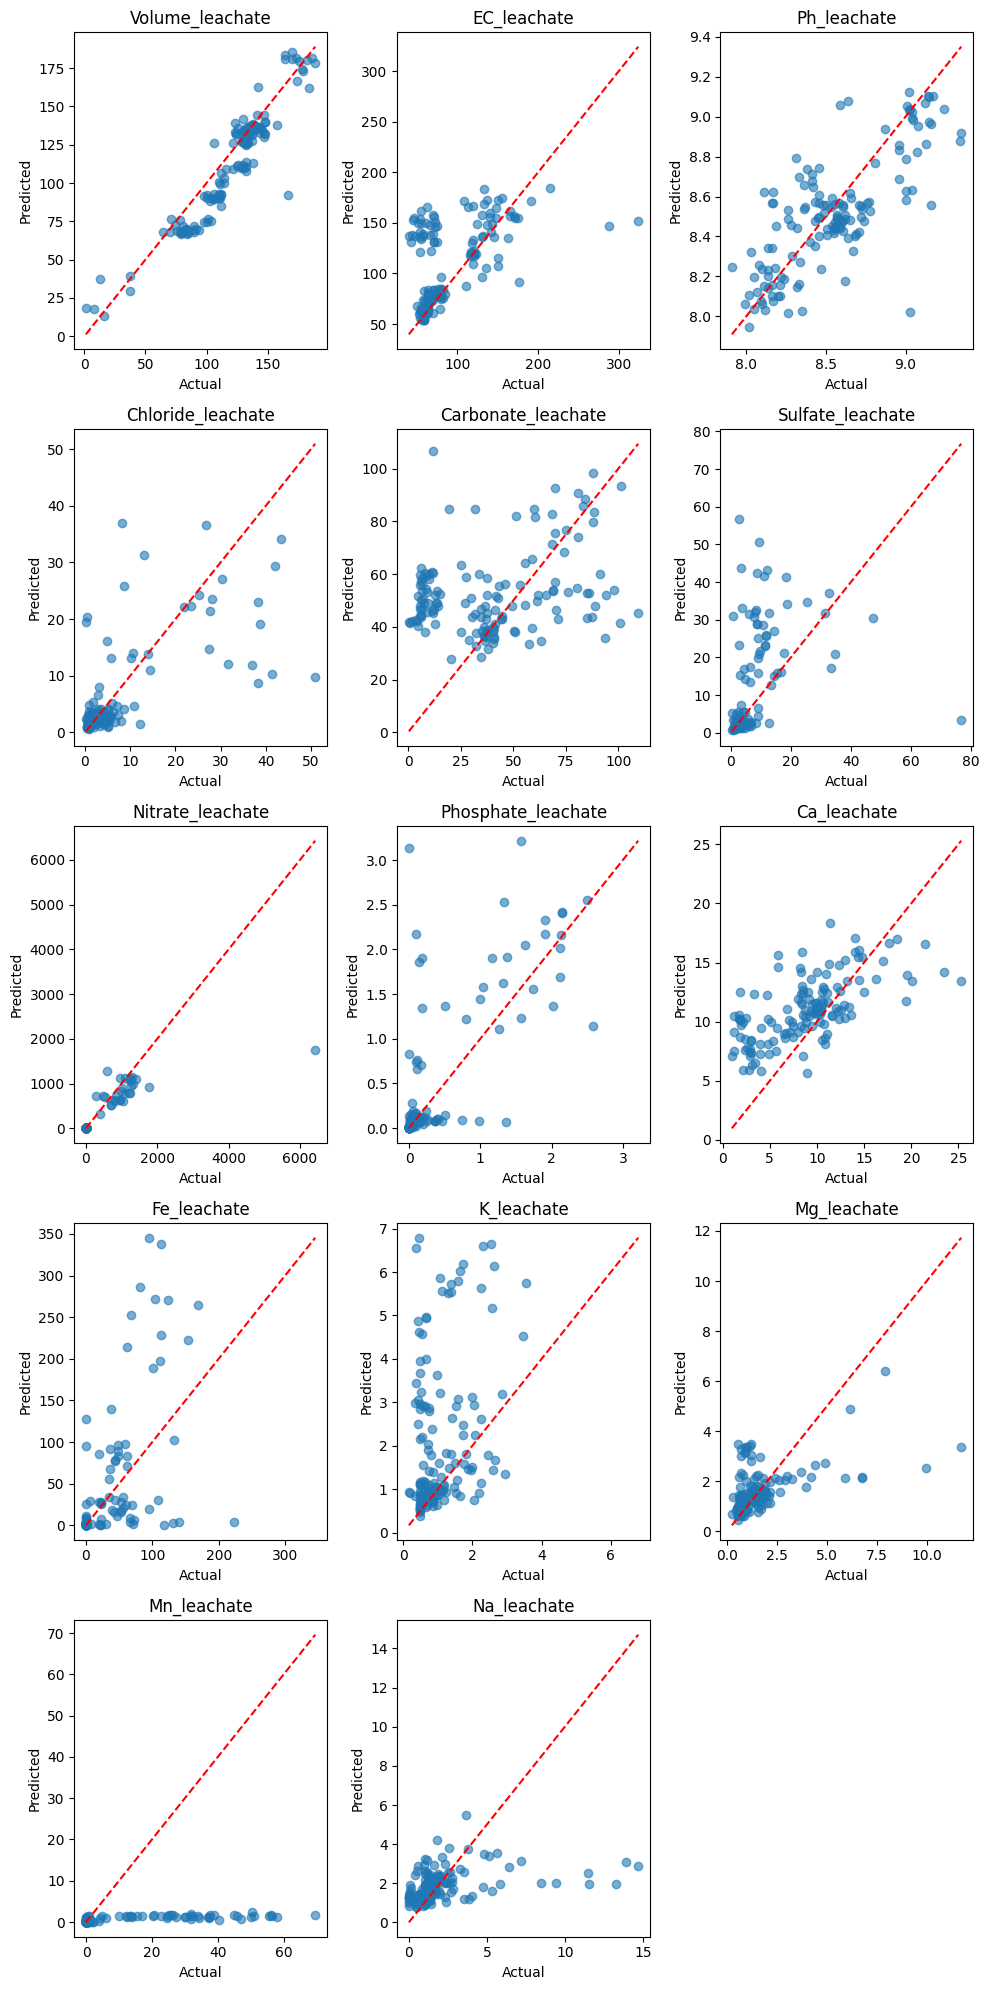

In [ ]:
n_cols = 3
n_rows = int(np.ceil(len(leachate_columns) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(leachate_columns):
    ax = axes[i]
    ax.scatter(y_test_reg[col].values, y_pred[col].values, alpha=0.6)
    # Add diagonal line for perfect prediction
    min_val = min(y_test_reg[col].min(), y_pred[col].min())
    max_val = max(y_test_reg[col].max(), y_pred[col].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--')
    ax.set_title(col)
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
#Save models
joblib.dump(best_models, "xgb_regressors.pkl")
joblib.dump(xgb_clf, "xgb_classifier.pkl")
joblib.dump(scaler, "scaler.pkl")
# list of categorical columns (one-hot encoded event features)
categorical_columns = df_train.filter(like="Type_event_").columns.tolist() + \
                      df_train.filter(like="Acid_").columns.tolist() + \
                      df_train.filter(like="Temp_level_").columns.tolist()
joblib.dump(categorical_columns, "categorical_columns.pkl")

# Save lag info
lag_settings = [1, 2, 3]  # example
joblib.dump(lag_settings, "lag_settings.pkl")
# Save the correct column order when training
feature_columns = X_train_reg.columns.tolist()
joblib.dump(feature_columns, "feature_columns.pkl")


['feature_columns.pkl']

## Whole pipeline combined on new data

In [9]:

# Load saved objects
best_models = joblib.load("xgb_regressors.pkl")
scaler = joblib.load("scaler.pkl")
categorical_columns = joblib.load("categorical_columns.pkl")
lag_settings = joblib.load("lag_settings.pkl")

numeric_predictors = ['EC_rock', 'Ph_rock', 'Corg_rock', 'SAR_rock',
                      'SiO2_rock', 'Al2O3_rock', 'Fe2O3_rock', 'SO3_rock',
                      'CaO_rock', 'MgO_rock']
feature_columns = joblib.load("feature_columns.pkl")

# After building df_row with all numeric, one-hot, and lag columns
# Ensure correct order
leachate_columns = list(best_models.keys())
xgb_clf= joblib.load("xgb_classifier.pkl")

In [ ]:
# Deployment function
def predict_leachate(rock_properties: dict, sequence: list):

    results = []

    # Initialize lag features
    lag_values = {f"{col}_lag{lag}": 0 for col in leachate_columns + ["Volume_leachate"] for lag in lag_settings}

    for i, event in enumerate(sequence):
        # Prepare row
        row = rock_properties.copy()
        row.update(lag_values)

        # Add event features
        for feat in ['Type_event', 'Acid', 'Temp_level']:
            row[feat] = event[feat]

        df_row = pd.DataFrame([row])

        # Scale numeric predictors
        df_row[numeric_predictors] = scaler.transform(df_row[numeric_predictors])

        # One-hot encode event features
        df_row = pd.get_dummies(df_row, columns=['Type_event','Acid','Temp_level'], drop_first=True)

        # Ensure all categorical columns exist
        for col in categorical_columns:
            if col not in df_row.columns:
                df_row[col] = 0
        df_row = df_row.reindex(columns=feature_columns, fill_value=0)

        # Classifier check
        high_volume_prob = xgb_clf.predict_proba(df_row)[:, 1][0]
        high_volume = high_volume_prob >= 0.2  # e.g., 0.5

        # Predict leachate if volume is high
        pred = {}
        if high_volume:
            for target in leachate_columns:
                model = best_models[target]
                # pred[target] = model.predict(df_row)[0]

                val = model.predict(df_row)[0]
                pred[target] = val
        else:
            for target in leachate_columns:
                pred[target] = 0  # or np.nan

        # Store prediction
        results.append(pred.copy())

        # Update lag values for next timestep
        for target in leachate_columns + ["Volume_leachate"]:
            val = pred[target] if target in pred else 0
            for lag in lag_settings:
                lag_values[f"{target}_lag{lag}"] = val if lag == 1 else lag_values[f"{target}_lag{lag-1}"]

    return pd.DataFrame(results)


In [49]:
# Example usage
rock_example = {
    'EC_rock': 1351, 'Ph_rock': 8.11, 'Corg_rock': 0.05, 'SAR_rock': 0.04,
    'SiO2_rock': 21.78, 'Al2O3_rock': 7.38, 'Fe2O3_rock': 3.16, 'SO3_rock': 24.65,
    'CaO_rock': 20.55, 'MgO_rock': 2.88
}

sequence_example = [
    {'Type_event':'rain', 'Acid':0, 'Temp_level':'low'},
    {'Type_event':'rain', 'Acid':1, 'Temp_level':'low'},
    {'Type_event':'rain', 'Acid':0, 'Temp_level':'high'},
    {'Type_event':'rain', 'Acid':0, 'Temp_level':'low'}

]

predictions = predict_leachate(rock_example, sequence_example)
print(predictions)

NameError: name 'predict_leachate' is not defined

In [ ]:
best_models

{'Volume_leachate': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, estimator__colsample_bytree=0.9,
              estimator__learning_rate=0.03, estimator__max_depth=3,
              estimator__min_child_weight=5, estimator__n_estimators=300,
              estimator__subsample=0.9, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, ...),
 'EC_leachate': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
           

In [53]:
class LeachatePipeline:
  def __init__(self, xgb_clf, best_models, scaler, categorical_columns, lag_settings, numeric_predictors, feature_columns, leachate_columns, log_targets):
    self.xgb_clf = xgb_clf
    self.best_models = best_models
    self.scaler = scaler
    self.categorical_columns = categorical_columns
    self.lag_settings = lag_settings
    self.numeric_predictors = numeric_predictors
    self.feature_columns = feature_columns
    self.leachate_columns = leachate_columns
    self.log_targets = log_targets

  def predict_leachate(self, rock_properties: dict, sequence: list):

    results = []
    processed_rows = []

    # Initialize lag features
    lag_values = {f"{col}_lag{lag}": 0 for col in self.leachate_columns + ["Volume_leachate"] for lag in self.lag_settings}

    for i, event in enumerate(sequence):
        # Prepare row
        row = rock_properties.copy()
        row.update(lag_values)

        # Add event features
        for feat in ['Type_event', 'Acid', 'Temp_level']:
            row[feat] = event[feat]

        df_row = pd.DataFrame([row])

        # Scale numeric predictors
        df_row[self.numeric_predictors] = self.scaler.transform(df_row[self.numeric_predictors])

        # One-hot encode event features
        df_row = pd.get_dummies(df_row, columns=['Type_event','Acid','Temp_level'], drop_first=True)

        # Ensure all categorical columns exist
        for col in self.categorical_columns:
            if col not in df_row.columns:
                df_row[col] = 0
        df_row = df_row.reindex(columns=self.feature_columns, fill_value=0)
        processed_rows.append(df_row)

        # Classifier check
        high_volume_prob = self.xgb_clf.predict_proba(df_row)[:, 1][0]
        high_volume = high_volume_prob >= 0.2  # e.g., 0.5

        # Predict leachate if volume is high
        pred = {}
        pred["Measured"] = 1 if high_volume else 0
        if high_volume:
            for target in self.leachate_columns:
                model = self.best_models[target]
                # pred[target] = model.predict(df_row)[0]

                val = model.predict(df_row)[0]
                # if target in self.log_targets:
                #     val = np.expm1(val)
                pred[target] = val
        else:
            for target in self.leachate_columns:
                pred[target] = 0  # or np.nan

        # Store prediction
        results.append(pred.copy())

        # Update lag values for next timestep
        for target in self.leachate_columns + ["Volume_leachate"]:
            val = pred[target] if target in pred else 0
            for lag in self.lag_settings:
                lag_values[f"{target}_lag{lag}"] = val if lag == 1 else lag_values[f"{target}_lag{lag-1}"]

    return pd.DataFrame(results), pd.concat(processed_rows, ignore_index=True)

In [54]:
rock_example = {
    'EC_rock': 1351, 'Ph_rock': 8.11, 'Corg_rock': 0.05, 'SAR_rock': 0.04,
    'SiO2_rock': 21.78, 'Al2O3_rock': 7.38, 'Fe2O3_rock': 3.16, 'SO3_rock': 24.65,
    'CaO_rock': 20.55, 'MgO_rock': 2.88
}

sequence_example = [
    {'Type_event':'rain', 'Acid':0, 'Temp_level':'low'},
    {'Type_event':'rain', 'Acid':1, 'Temp_level':'low'},
    {'Type_event':'rain', 'Acid':0, 'Temp_level':'high'},

]
# pipeline = LeachatePipeline(
#     xgb_clf=xgb_clf,
#     best_models=best_models,
#     scaler=scaler,
#     categorical_columns=categorical_columns,
#     lag_settings=lag_settings,
#     numeric_predictors=numeric_predictors,
#     feature_columns=feature_columns,
#     leachate_columns=leachate_columns,
#     log_targets=log_targets
# )

pipeline = joblib.load("pipeline.pkl")

predictions, wheri = pipeline.predict_leachate(rock_example, sequence_example)
# print(rock_example)
# print(sequence_example)
print(predictions)

   Measured  Volume_leachate  EC_leachate  Ph_leachate  Chloride_leachate  \
0         1        19.294529     5.083185     7.608767           2.253474   
1         1       104.378540     5.135678     7.948421           2.460914   
2         1       107.726608     4.540296     8.108405           1.451364   

   Carbonate_leachate  Sulfate_leachate  Nitrate_leachate  Phosphate_leachate  \
0            2.624553          2.152150          5.918472            0.667218   
1            2.695054          1.383398          6.324971            0.430865   
2            2.548267          1.156445          0.461234            0.543814   

   Ca_leachate  Fe_leachate  K_leachate  Mg_leachate  Mn_leachate  Na_leachate  
0     4.475872     2.860535    0.883597     1.596062     2.539319     0.932744  
1     4.430389     4.153388    0.766808     1.215537     2.749852     0.735837  
2     4.454607     4.568854    0.563177     1.965006     3.762790     0.818760  


In [33]:
joblib.dump(pipeline, "pipeline.pkl")


['pipeline.pkl']

In [55]:
!pip freeze

absl-py==1.4.0
accelerate==1.12.0
access==1.1.9
affine==2.4.0
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.13.2
aiosignal==1.4.0
aiosqlite==0.21.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
alembic==1.17.2
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.12.0
anywidget==0.9.21
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
array_record==0.8.3
arrow==1.4.0
arviz==0.22.0
astropy==7.2.0
astropy-iers-data==0.2025.12.8.0.38.44
astunparse==1.6.3
atpublic==5.1
attrs==25.4.0
audioread==3.1.0
Authlib==1.6.5
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
beartype==0.22.8
beautifulsoup4==4.13.5
betterproto==2.0.0b6
bigframes==2.30.0
bigquery-magics==0.10.3
bleach==6.3.0
blinker==1.9.0
blis==1.3.3
blobfile==3.1.0
blosc2==3.12.2
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.2
brotli==1.2.0
CacheControl==0.14.4
cachetools==6.2.2
catalogue==2.0.10
certifi==2025.11.12
cffi==2.0.0
chardet==5.2.0
charset-normalizer==3.4.4
chex==